In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title, image):
    """
    顯示影像的輔助函式
    :param title: 影像標題
    :param image: 影像資料
    """
    plt.figure()
    if len(image.shape) == 2:  # 灰階影像
        plt.imshow(image, cmap='gray')
    else:  # 彩色影像
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def motion_blur(image, kernel_size, angle):
    """
    對影像添加運動模糊效果，並顯示每一步驟
    :param image: 原始影像 (彩色或灰階)
    :param kernel_size: 模糊核大小
    :param angle: 模糊方向角度
    :return: 添加模糊後的影像
    """
    # 初始化模糊核
    kernel = np.zeros((kernel_size, kernel_size))  # 開一個全黑畫布
    center = kernel_size // 2  # 計算核的中心位置
    cv2.line(kernel, (center, 0), (center, kernel_size - 1), 1, thickness=1)  # 在核中畫一條垂直的直線

    # 使用子圖顯示影像
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(kernel, cmap='gray')
    plt.title("Initial Kernel (Line)")
    plt.axis('off')


    # 旋轉模糊核
    rotation_matrix = cv2.getRotationMatrix2D((center, center), angle, 1)  # 生成旋轉矩陣
    kernel = cv2.warpAffine(kernel, rotation_matrix, (kernel_size, kernel_size))  # 將旋轉矩陣應用到模糊核上

    # 標準化模糊核
    kernel /= kernel.sum()

    # 對影像進行濾波
    blurred = cv2.filter2D(image, -1, kernel)

    plt.subplot(1, 3, 2)
    plt.imshow(kernel, cmap='gray')
    plt.title("Rotated Kernel")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(blurred)
    plt.title("Blurred Image")
    plt.axis('off')

    plt.show()

    return blurred, kernel

def wiener_filter(image, kernel, K=0.01):
    """
    使用維納濾波還原模糊影像，並顯示每一步驟
    :param image: 模糊影像 (彩色或灰階)
    :param kernel: 模糊核
    :param K: 噪聲功率比
    :return: 還原後的影像
    """
    result = np.zeros_like(image)
    plt.figure(figsize=(12, 8))

    if len(image.shape) == 2:  # 灰階影像
        kernel_padded = np.pad(kernel, [(0, image.shape[0] - kernel.shape[0]), 
                                        (0, image.shape[1] - kernel.shape[1])], 
                               mode='constant')

        kernel_fft = np.fft.fft2(kernel_padded)
        image_fft = np.fft.fft2(image)

        kernel_conj = np.conj(kernel_fft)
        wiener_result = (kernel_conj / (np.abs(kernel_fft)**2 + K)) * image_fft
        result = np.abs(np.fft.ifft2(wiener_result))

        # Show images and FFT spectrum
        plt.subplot(2, 3, 1)
        plt.imshow(kernel, cmap='gray')
        plt.title("Kernel")
        plt.axis('off')

        plt.subplot(2, 3, 2)
        plt.imshow(image, cmap='gray')
        plt.title("Blurred Image")
        plt.axis('off')

        plt.subplot(2, 3, 3)
        plt.imshow(np.log(1 + np.abs(image_fft)), cmap='gray')
        plt.title("FFT of Blurred Image")
        plt.axis('off')

        plt.subplot(2, 3, 4)
        plt.imshow(np.log(1 + np.abs(np.fft.fft2(image))), cmap='gray')
        plt.title("FFT of Original Image")
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.imshow(np.abs(kernel_fft), cmap='gray')
        plt.title("FFT of Kernel")
        plt.axis('off')

        plt.subplot(2, 3, 6)
        plt.imshow(result, cmap='gray')
        plt.title("Restored Image")
        plt.axis('off')

    else:  # 彩色影像
        for i in range(image.shape[2]):  # 對每個通道處理
            channel = image[:, :, i]
            kernel_padded = np.pad(kernel, [(0, channel.shape[0] - kernel.shape[0]), 
                                            (0, channel.shape[1] - kernel.shape[1])], 
                                   mode='constant')
            kernel_fft = np.fft.fft2(kernel_padded)
            channel_fft = np.fft.fft2(channel)
            kernel_conj = np.conj(kernel_fft)
            wiener_result = (kernel_conj / (np.abs(kernel_fft)**2 + K)) * channel_fft
            result[:, :, i] = np.abs(np.fft.ifft2(wiener_result))

        # Show images and FFT spectrum for each channel
        for i in range(image.shape[2]):

            plt.subplot(4, 3, i + 1)
            plt.imshow(image[:, :, i])
            plt.title(f"Blurred Image Channel {i+1}")
            plt.axis('off')

            plt.subplot(4, 3, i + 4)
            plt.imshow(np.log(1 + np.abs(np.fft.fft2(image[:, :, i]))), cmap='gray')
            plt.title(f"FFT of Blurred Image Channel {i+1}")
            plt.axis('off')

            plt.subplot(4, 3, i + 7)
            plt.imshow(result[:, :, i])
            plt.title(f"Restored Image Channel {i+1}")


            plt.subplot(4, 3, i + 10)
            plt.imshow(np.log(1 + np.abs(np.fft.fft2(result[:, :, i]))), cmap='gray')
            plt.title(f"FFT of Restored Image Channel {i+1}")
            plt.axis('off')

            plt.axis('off')

    plt.tight_layout()
    plt.show()
    return result

In [3]:


def process_image(filename, kernel_size=200, angle=90, K=0.01):
    # 讀取原始影像
    original_img = cv2.imread(filename, cv2.IMREAD_COLOR)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # 將 BGR 轉為 RGB 以便 Matplotlib 顯示

    # 模擬動態模糊
    print(f"motion_blur: (kernel_size = {kernel_size}, angle = {angle}) ")
    blurred_img, blur_kernel = motion_blur(original_img, kernel_size, angle)

    # 還原模糊影像
    print(f"wiener_filter: (K = {K}) ")
    restored_img = wiener_filter(blurred_img, blur_kernel, K=K)

    # 使用子圖顯示影像
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(blurred_img)
    plt.title("Blurred Image")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(restored_img)
    plt.title("Restored Image")
    plt.axis('off')

    # Show FFT of Original Image

    for i in range(original_img.shape[2]):

        plt.subplot(2, 3, i + 4)
        plt.imshow(np.log(1 + np.abs(np.fft.fft2(original_img[:, :, i]))), cmap='gray')
        plt.title(f"FFT of Original Image Channel {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return original_img, blurred_img, restored_img

motion_blur: (kernel_size = 200, angle = 90) 


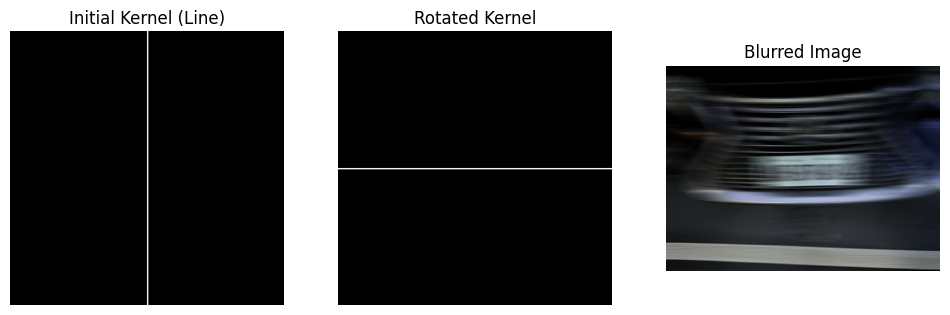

wiener_filter: (K = 0.02) 


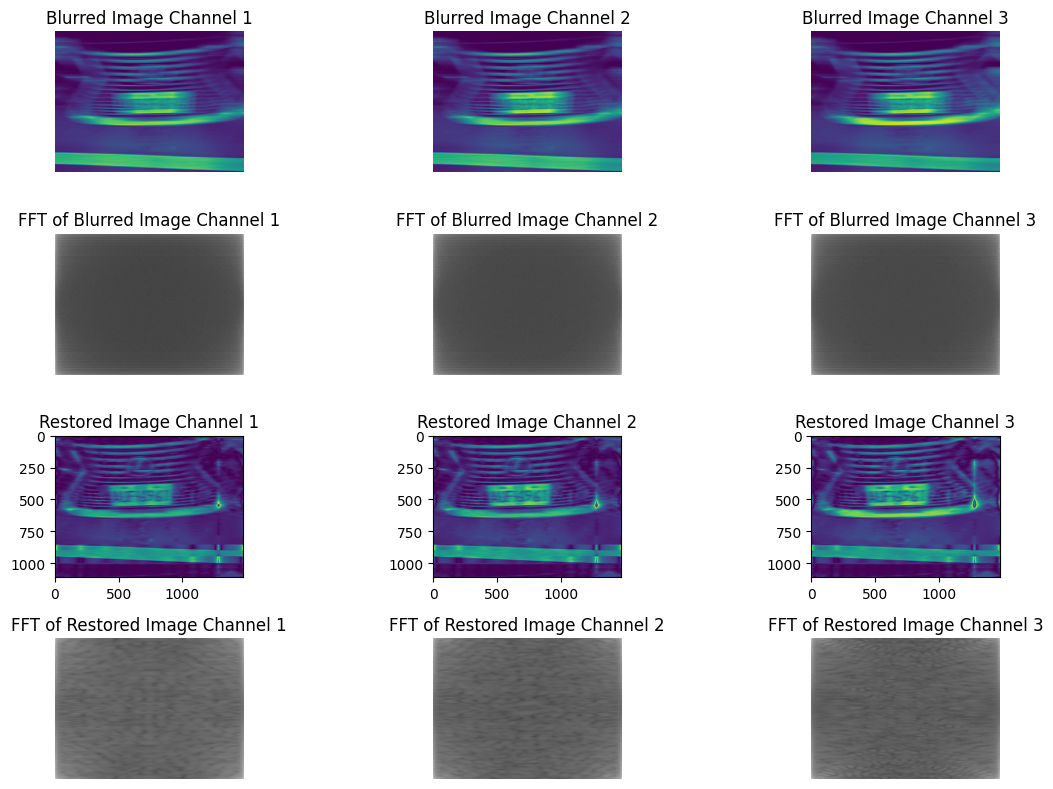

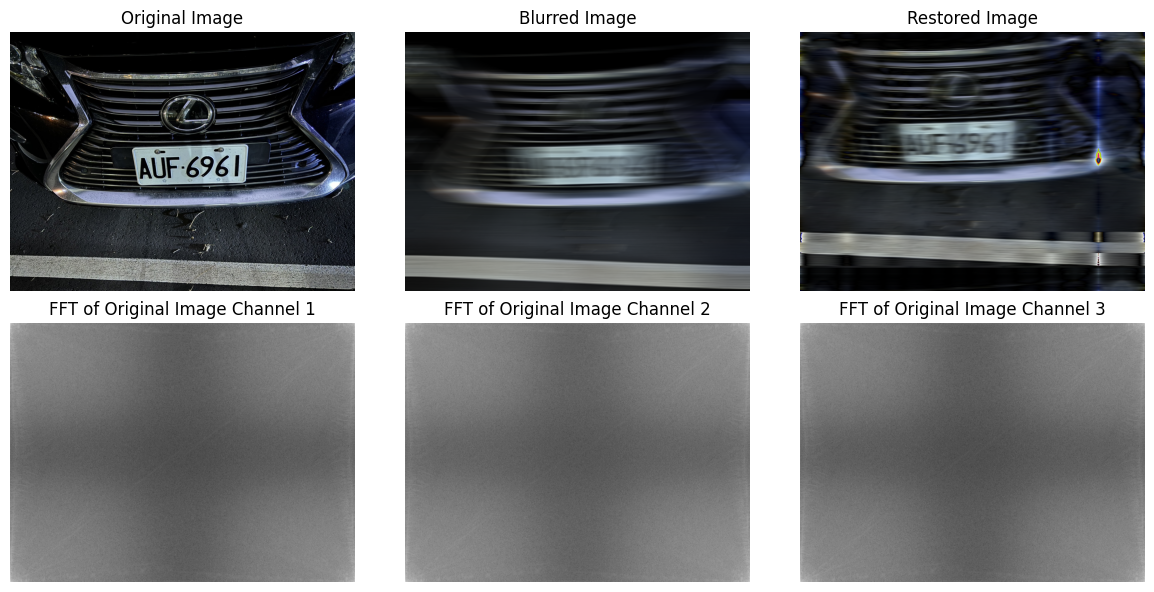

In [4]:

o, b, r = process_image("../imgs/AUF6961.jpg", K=0.02) 

motion_blur: (kernel_size = 250, angle = 40) 


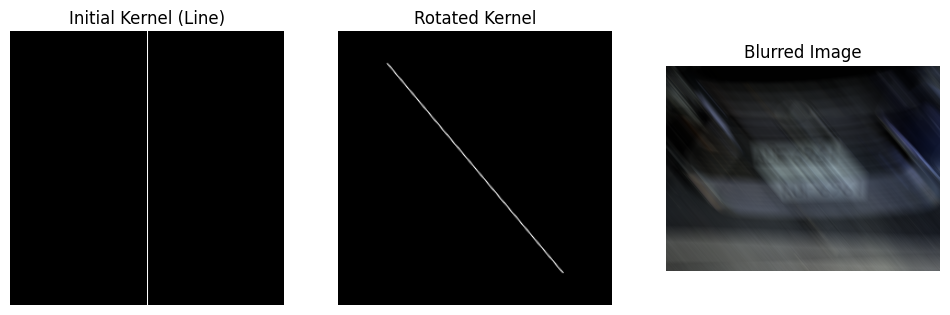

wiener_filter: (K = 0.013) 


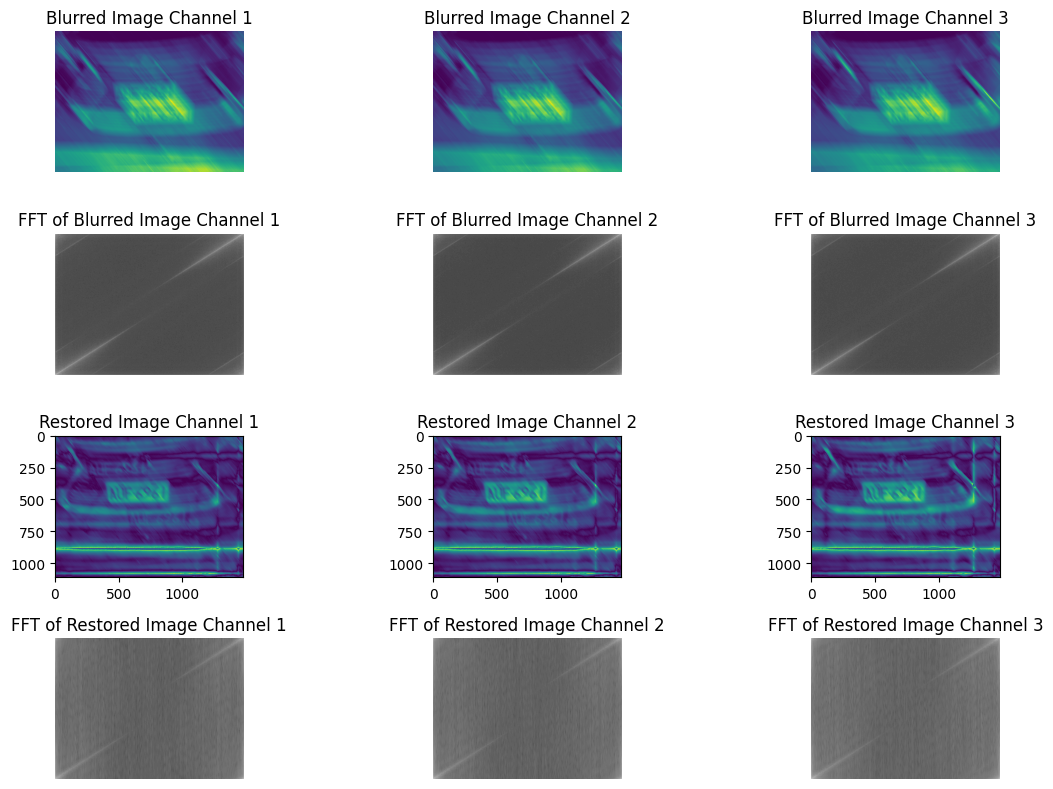

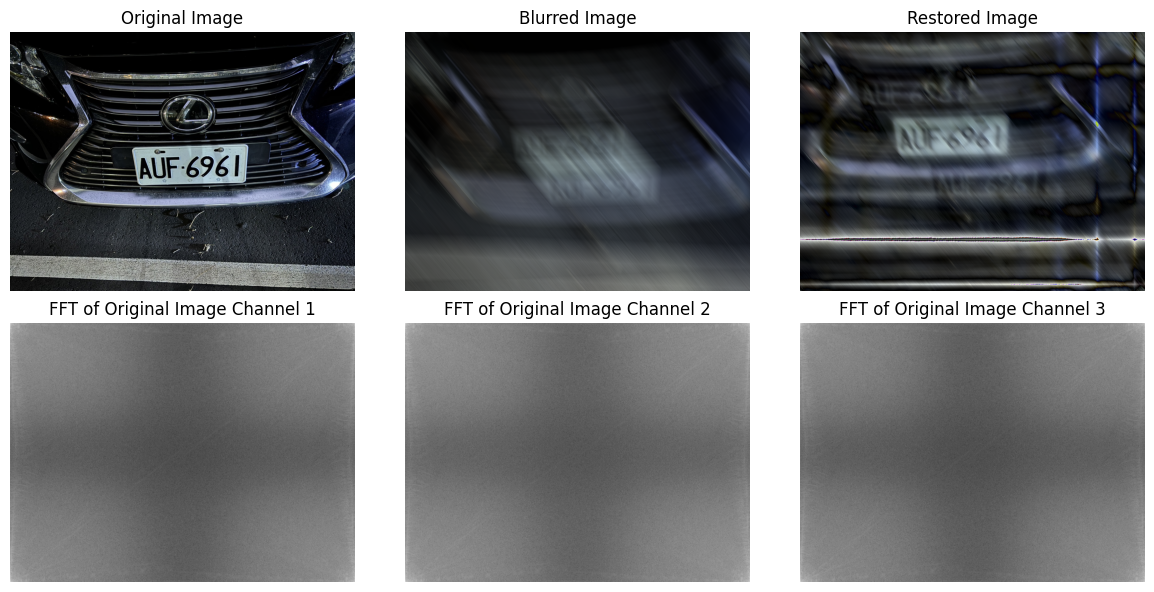

In [6]:

o, b, r = process_image("../imgs/AUF6961.jpg", kernel_size=250, angle=40, K=0.013)

motion_blur: (kernel_size = 80, angle = 130) 


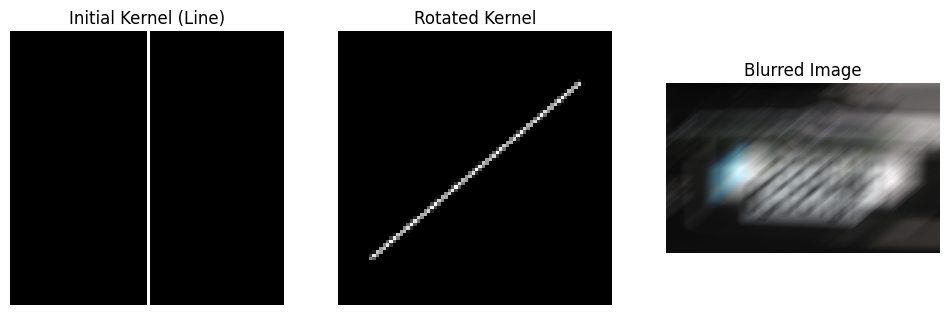

wiener_filter: (K = 0.007) 


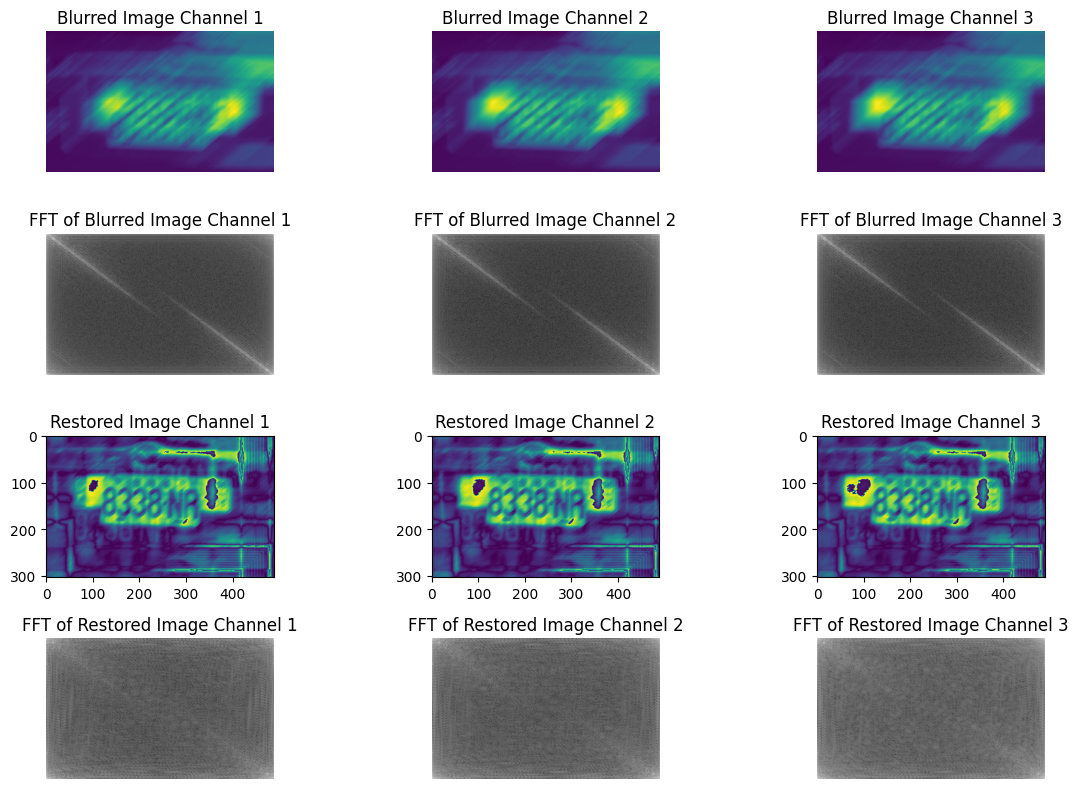

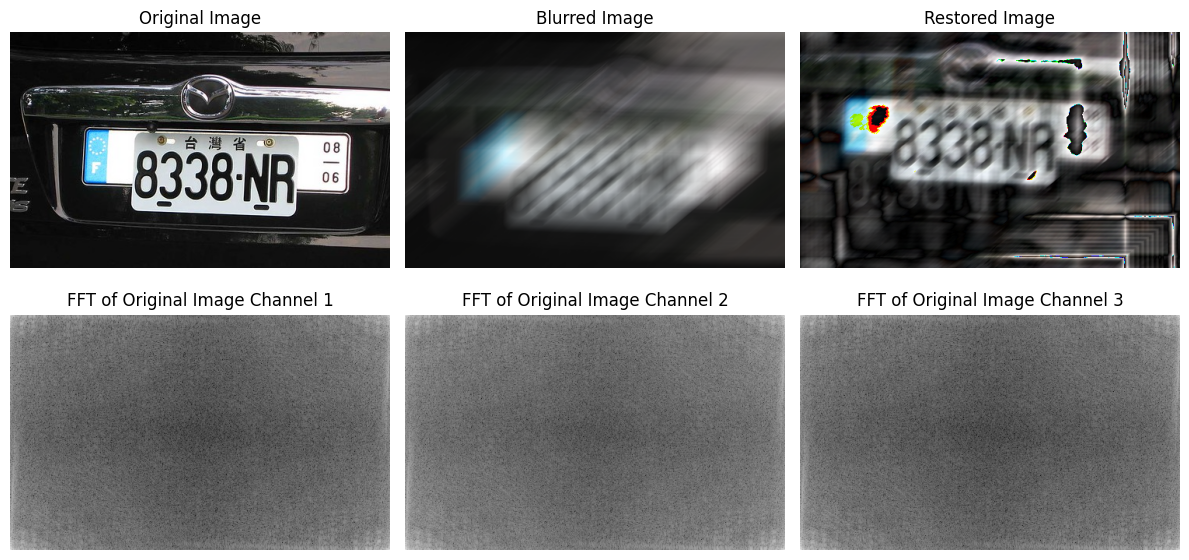

In [9]:
images = process_image("../imgs/8338NR.png", kernel_size=80, angle=130, K=0.007) 